In [48]:
import pandas as pd
import numpy as np
import time
import copy
import yfinance as yf

In [49]:
def ATR(DF,n):
    df=DF.copy()
    df["H-L"]=df["High"]-df["Low"]
    df["H-PC"]=df["High"]-df["Adj Close"].shift(1)
    df["L-PC"]=df["Low"]-df["Adj Close"].shift(1)
    df["TR"]=df[["H-L","H-PC","L-PC"]].max(axis=1,skipna=False)
    #df["ATR"]=df["TR"].ewm(com=n,min_periods=n).mean()
    df['ATR'] = df['TR'].rolling(n).mean()
    df2 = df.drop(['H-L','H-PC','L-PC'],axis=1)
    return df2["ATR"]

def CAGR(DF):
    df=DF.copy()
    df["cumreturn"]=(1+df["ret"]).cumprod()
    n=len(df)/(252*78)
    CAGR=(df["cumreturn"].tolist()[-1])**(1/n)-1
    return CAGR

def VOL(DF):
    df=DF.copy()
    vol=df["ret"].std()* np.sqrt(252*78)
    return vol

def sharpe(DF,rf):
    df=DF.copy()
    sr=(CAGR(df)-rf)/VOL(df)
    return sr
    
def max_dd(DF):
    df=DF.copy()
    df["cumreturn"]=(1+df["ret"]).cumprod()
    df["cum_roll_max"]=df["cumreturn"].cummax()
    df["drawdown"]=(df["cum_roll_max"])-df["cumreturn"]
    df["drawdown_pct"] = df["drawdown"]/df["cum_roll_max"]
    max_dd= df["drawdown_pct"].max()
    return max_dd

In [50]:
tickers=["TCS.NS","INFY.NS"]
ohlc_intraday_keys={}

In [51]:
for ticker in tickers:
    temp=yf.download(ticker,period='1mo',interval='5m')
    temp.dropna(how='any',inplace=True)
    ohlc_intraday_keys[ticker]=temp

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [52]:
ohlc_intraday_keys

{'TCS.NS':                                   Open         High          Low        Close  \
 Datetime                                                                        
 2023-08-23 09:15:00+05:30  3389.000000  3402.000000  3389.000000  3399.699951   
 2023-08-23 09:20:00+05:30  3400.500000  3400.800049  3390.000000  3394.500000   
 2023-08-23 09:25:00+05:30  3393.250000  3398.149902  3386.250000  3387.649902   
 2023-08-23 09:30:00+05:30  3386.600098  3398.000000  3386.100098  3397.100098   
 2023-08-23 09:35:00+05:30  3397.000000  3401.000000  3395.000000  3395.000000   
 ...                                ...          ...          ...          ...   
 2023-09-22 15:05:00+05:30  3606.850098  3610.000000  3606.500000  3610.000000   
 2023-09-22 15:10:00+05:30  3609.949951  3610.000000  3600.100098  3600.350098   
 2023-09-22 15:15:00+05:30  3600.300049  3600.350098  3588.149902  3600.000000   
 2023-09-22 15:20:00+05:30  3599.000000  3610.199951  3599.000000  3601.399902   
 2023-

In [53]:
# calculating ATR and rolling max price for each stock and consolidating this info by stock in a separate dataframe

ohlc_dict=copy.deepcopy(ohlc_intraday_keys)
tickers_signal={}
tickers_ret={}

for ticker in tickers:
    print("Calculating ATR and rolling max price for",ticker)
    ohlc_dict[ticker]["ATR"]=ATR(ohlc_dict[ticker],20)
    ohlc_dict[ticker]["roll_max_cp"]=ohlc_dict[ticker]["High"].rolling(20).max()
    ohlc_dict[ticker]["roll_min_cp"]=ohlc_dict[ticker]["Low"].rolling(20).min()
    ohlc_dict[ticker]["roll_max_vol"]=ohlc_dict[ticker]["Volume"].rolling(20).max()
    ohlc_dict[ticker].dropna(inplace=True)
    tickers_signal[ticker]=""
    tickers_ret[ticker]=[0]

Calculating ATR and rolling max price for TCS.NS
Calculating ATR and rolling max price for INFY.NS


In [54]:
ohlc_dict

{'TCS.NS':                                   Open         High          Low        Close  \
 Datetime                                                                        
 2023-08-23 10:55:00+05:30  3384.800049  3386.949951  3383.000000  3386.250000   
 2023-08-23 11:00:00+05:30  3386.199951  3386.500000  3383.500000  3385.000000   
 2023-08-23 11:05:00+05:30  3385.000000  3387.350098  3384.000000  3387.350098   
 2023-08-23 11:10:00+05:30  3386.350098  3387.850098  3385.500000  3387.149902   
 2023-08-23 11:15:00+05:30  3387.000000  3387.100098  3384.300049  3386.949951   
 ...                                ...          ...          ...          ...   
 2023-09-22 15:05:00+05:30  3606.850098  3610.000000  3606.500000  3610.000000   
 2023-09-22 15:10:00+05:30  3609.949951  3610.000000  3600.100098  3600.350098   
 2023-09-22 15:15:00+05:30  3600.300049  3600.350098  3588.149902  3600.000000   
 2023-09-22 15:20:00+05:30  3599.000000  3610.199951  3599.000000  3601.399902   
 2023-

In [55]:
# identifying signals and calculating daily return (stop loss factored in)
for ticker in tickers:
    print("calculating returns for ",ticker)
    for i in range(1,len(ohlc_dict[ticker])):
        if tickers_signal[ticker] == "":
            tickers_ret[ticker].append(0)
            if ohlc_dict[ticker]["High"][i]>=ohlc_dict[ticker]["roll_max_cp"][i] and \
               ohlc_dict[ticker]["Volume"][i]>1.5*ohlc_dict[ticker]["roll_max_vol"][i-1]:
                tickers_signal[ticker] = "Buy"
            elif ohlc_dict[ticker]["Low"][i]<=ohlc_dict[ticker]["roll_min_cp"][i] and \
               ohlc_dict[ticker]["Volume"][i]>1.5*ohlc_dict[ticker]["roll_max_vol"][i-1]:
                tickers_signal[ticker] = "Sell"
        
        elif tickers_signal[ticker] == "Buy":
            if ohlc_dict[ticker]["Low"][i]<ohlc_dict[ticker]["Close"][i-1] - ohlc_dict[ticker]["ATR"][i-1]:
                tickers_signal[ticker] = ""
                tickers_ret[ticker].append(((ohlc_dict[ticker]["Close"][i-1] - ohlc_dict[ticker]["ATR"][i-1])/ohlc_dict[ticker]["Close"][i-1])-1)
            elif ohlc_dict[ticker]["Low"][i]<=ohlc_dict[ticker]["roll_min_cp"][i] and \
               ohlc_dict[ticker]["Volume"][i]>1.5*ohlc_dict[ticker]["roll_max_vol"][i-1]:
                tickers_signal[ticker] = "Sell"
                tickers_ret[ticker].append((ohlc_dict[ticker]["Close"][i]/ohlc_dict[ticker]["Close"][i-1])-1)
            else:
                tickers_ret[ticker].append((ohlc_dict[ticker]["Close"][i]/ohlc_dict[ticker]["Close"][i-1])-1)
                
        elif tickers_signal[ticker] == "Sell":
            if ohlc_dict[ticker]["High"][i]>ohlc_dict[ticker]["Close"][i-1] + ohlc_dict[ticker]["ATR"][i-1]:
                tickers_signal[ticker] = ""
                tickers_ret[ticker].append((ohlc_dict[ticker]["Close"][i-1]/(ohlc_dict[ticker]["Close"][i-1] + ohlc_dict[ticker]["ATR"][i-1]))-1)
            elif ohlc_dict[ticker]["High"][i]>=ohlc_dict[ticker]["roll_max_cp"][i] and \
               ohlc_dict[ticker]["Volume"][i]>1.5*ohlc_dict[ticker]["roll_max_vol"][i-1]:
                tickers_signal[ticker] = "Buy"
                tickers_ret[ticker].append((ohlc_dict[ticker]["Close"][i-1]/ohlc_dict[ticker]["Close"][i])-1)
            else:
                tickers_ret[ticker].append((ohlc_dict[ticker]["Close"][i-1]/ohlc_dict[ticker]["Close"][i])-1)
                
    ohlc_dict[ticker]["ret"] = np.array(tickers_ret[ticker])





calculating returns for  TCS.NS
calculating returns for  INFY.NS


In [56]:
  ohlc_dict[ticker]["ret"]

Datetime
2023-08-23 10:55:00+05:30    0.0
2023-08-23 11:00:00+05:30    0.0
2023-08-23 11:05:00+05:30    0.0
2023-08-23 11:10:00+05:30    0.0
2023-08-23 11:15:00+05:30    0.0
                            ... 
2023-09-22 15:05:00+05:30    0.0
2023-09-22 15:10:00+05:30    0.0
2023-09-22 15:15:00+05:30    0.0
2023-09-22 15:20:00+05:30    0.0
2023-09-22 15:25:00+05:30    0.0
Name: ret, Length: 1630, dtype: float64

In [57]:
ohlc_dict

{'TCS.NS':                                   Open         High          Low        Close  \
 Datetime                                                                        
 2023-08-23 10:55:00+05:30  3384.800049  3386.949951  3383.000000  3386.250000   
 2023-08-23 11:00:00+05:30  3386.199951  3386.500000  3383.500000  3385.000000   
 2023-08-23 11:05:00+05:30  3385.000000  3387.350098  3384.000000  3387.350098   
 2023-08-23 11:10:00+05:30  3386.350098  3387.850098  3385.500000  3387.149902   
 2023-08-23 11:15:00+05:30  3387.000000  3387.100098  3384.300049  3386.949951   
 ...                                ...          ...          ...          ...   
 2023-09-22 15:05:00+05:30  3606.850098  3610.000000  3606.500000  3610.000000   
 2023-09-22 15:10:00+05:30  3609.949951  3610.000000  3600.100098  3600.350098   
 2023-09-22 15:15:00+05:30  3600.300049  3600.350098  3588.149902  3600.000000   
 2023-09-22 15:20:00+05:30  3599.000000  3610.199951  3599.000000  3601.399902   
 2023-

calculating KPIs for  TCS.NS
calculating KPIs for  INFY.NS


,Return,Sharpe Ratio,Max Drawdown
TCS.NS,0.057414,0.982555,0.011066
INFY.NS,-0.161049,-5.792127,0.014942


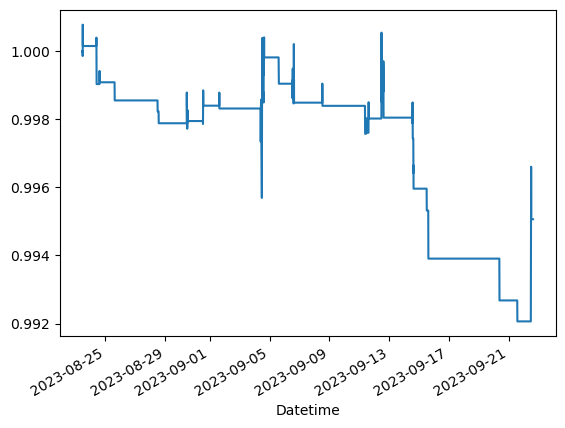

In [58]:
# calculating overall strategy's KPIs
strategy_df = pd.DataFrame()
for ticker in tickers:
    strategy_df[ticker] = ohlc_dict[ticker]["ret"]
strategy_df["ret"] = strategy_df.mean(axis=1)
CAGR(strategy_df)
sharpe(strategy_df,0.025)
max_dd(strategy_df)  


# vizualization of strategy return
(1+strategy_df["ret"]).cumprod().plot()


#calculating individual stock's KPIs
cagr = {}
sharpe_ratios = {}
max_drawdown = {}
for ticker in tickers:
    print("calculating KPIs for ",ticker)      
    cagr[ticker] =  CAGR(ohlc_dict[ticker])
    sharpe_ratios[ticker] =  sharpe(ohlc_dict[ticker],0.025)
    max_drawdown[ticker] =  max_dd(ohlc_dict[ticker])

KPI_df = pd.DataFrame([cagr,sharpe_ratios,max_drawdown],index=["Return","Sharpe Ratio","Max Drawdown"])      
KPI_df.T
